In [353]:
# Select images set
SET = 'rot270'

----

In [354]:
import numpy as np
import pandas as pd
import os
import SimpleITK as sitk
from glob import glob

import matplotlib.pyplot as plt

### paths

In [355]:
SET_DIR = '../sets/' + SET + '/'
TRAIN_IMG_DIR = SET_DIR + 'nodules/train/'
TEST_IMG_DIR = SET_DIR + 'nodules/test/'
VAL_IMG_DIR = SET_DIR + 'nodules/val/'
IMG_PREF = 'nodule_'
IMG_EXT = '.jpg'

### read pickle

In [356]:
X_train = pd.read_pickle(SET_DIR + 'pickle/traindata')
X_test = pd.read_pickle(SET_DIR + 'pickle/testdata')
X_val = pd.read_pickle(SET_DIR + 'pickle/valdata')
y_train = pd.read_pickle(SET_DIR + 'pickle/trainlabels')
y_test = pd.read_pickle(SET_DIR + 'pickle/testlabels')
y_val = pd.read_pickle(SET_DIR + 'pickle/vallabels')

In [357]:
print('TRAINING DATA')
print('Total examples: ', len(y_train))
print('Total positives: ', y_train.sum())
print(format((y_train.sum() / len(y_train)) * 100, '.2f'), '%')

TRAINING DATA
Total examples:  15113
Total positives:  4300.0
28.45 %


In [358]:
print('TESTING DATA')
print('Total examples: ', len(y_test))
print('Total positives: ', y_test.sum())
print(format((y_test.sum() / len(y_test)) * 100, '.2f'), '%')

TESTING DATA
Total examples:  2973
Total positives:  232
7.80 %


----
### change negative size (optional)

In [359]:
X_train

,seriesuid,coordX,coordY,coordZ
442824,1.3.6.1.4.1.14519.5.2.1.6279.6001.440226700369...,42.580000,-105.410000,-168.900000
462788,1.3.6.1.4.1.14519.5.2.1.6279.6001.518487185634...,-142.942334,6.301840,-223.126667
40899,1.3.6.1.4.1.14519.5.2.1.6279.6001.122914038048...,-144.537000,78.477400,-290.129000
73165,1.3.6.1.4.1.14519.5.2.1.6279.6001.139713436241...,-123.985174,19.288018,-210.801957
194094,1.3.6.1.4.1.14519.5.2.1.6279.6001.204287915902...,-107.654586,39.966731,-206.102586
...,...,...,...,...
3162840,1.3.6.1.4.1.14519.5.2.1.6279.6001.188265424231...,-60.617275,70.697839,-57.825056
3146099,1.3.6.1.4.1.14519.5.2.1.6279.6001.178391668569...,96.140000,-21.720000,-154.590000
3058637,1.3.6.1.4.1.14519.5.2.1.6279.6001.131939324905...,-59.545794,83.652696,1369.677277
3018656,1.3.6.1.4.1.14519.5.2.1.6279.6001.110678335949...,-39.483881,-108.962047,-139.661218


In [360]:
neg_ids = X_train[y_train == 0].index
pos_ids = X_train[y_train == 1].index 
neg_ids = np.random.choice(neg_ids, int(len(pos_ids)), replace = False)

In [361]:
X_train = X_train.loc[list(pos_ids) + list(neg_ids)]
y_train = y_train.loc[list(pos_ids) + list(neg_ids)]

In [362]:
print('TRAINING DATA')
print('Total examples: ', len(y_train))
print('Total positives: ', y_train.sum())
print(format((y_train.sum() / len(y_train)) * 100, '.2f'), '%')

TRAINING DATA
Total examples:  8600
Total positives:  4300.0
50.00 %


----

### create h5py files

In [363]:
import h5py
import PIL

In [364]:
def create_h5py(mode):
    if mode == 'train':
        X = X_train
        y = y_train
        DIR = TRAIN_IMG_DIR
    elif mode == 'test':
        X = X_test
        y = y_test
        DIR = TEST_IMG_DIR
    elif mode == 'val':
        X = X_val
        y = y_val
        DIR = VAL_IMG_DIR
    
    f = h5py.File('../h5py/malaCAD' + mode + '.hdf5', 'w')
    
    # Create classes (labels) dataset
    f.create_dataset(mode + '_labels', shape = (len(y),))
    f[mode + '_labels'][...] = list(y)
    
    # Create images dataset
    f.create_dataset(mode + '_img', shape = (len(X), 50, 50))
    index = 0
    for col in X.transpose():
        image = PIL.Image.open(DIR + IMG_PREF + str(col) + IMG_EXT)
        f[mode + '_img'][index, ...] = image
        index += 1
    
    f.close()
    
    f = h5py.File('../h5py/malaCAD' + mode + '.hdf5', 'r')
    X_ret = f[mode + '_img'] [...]
    y_ret = f[mode + '_labels'][...]
    f.close()
    
    return (X_ret, y_ret)

In [365]:
input_train, label_train = create_h5py('train')
input_test, label_test = create_h5py('test')
input_val, label_val = create_h5py('val')

## CNN

In [366]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [367]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPool2D
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

In [368]:
# Model configuration
batch_size = 50
img_width, img_height, img_num_channels = 50, 50, 1
loss_function = binary_crossentropy
no_classes = 1
no_epochs = 10
optimizer = Adam()
validation_split = 0.2
verbosity = 1

In [369]:
# Reshape data
input_train = input_train.reshape(len(input_train), img_width, img_height, img_num_channels)
input_test = input_test.reshape(len(input_test), img_width, img_height, img_num_channels)
input_val = input_val.reshape(len(input_val), img_width, img_height, img_num_channels)

input_shape = (img_width, img_height, img_num_channels)

In [370]:
print(len(input_train))
print(len(input_test))
print(len(input_val))

8600
2973
2973


In [371]:
# Create the model
model = Sequential()
model.add(Conv2D(50, kernel_size=(3, 3), activation='relu', input_shape = input_shape))
model.add(MaxPool2D())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(no_classes, activation='sigmoid'))

# Display model summary
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 48, 48, 50)        500       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 24, 24, 50)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 22, 22, 64)        28864     
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 20, 20, 64)        36928     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 6400)              0         
_________________________________________________________________
dense_41 (Dense)             (None, 128)             

In [372]:
# Compile the model
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

### train model

In [373]:
model.fit(input_train, label_train,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_data=(input_val, label_val))

Train on 8600 samples, validate on 2973 samples
Epoch 1/10
8600/8600 [==============================] - 74s 9ms/sample - loss: 0.8877 - accuracy: 0.7309 - val_loss: 0.4951 - val_accuracy: 0.8015
Epoch 2/10
8600/8600 [==============================] - 73s 8ms/sample - loss: 0.3412 - accuracy: 0.8579 - val_loss: 0.3980 - val_accuracy: 0.8483
Epoch 3/10
8600/8600 [==============================] - 73s 8ms/sample - loss: 0.2689 - accuracy: 0.8947 - val_loss: 0.2730 - val_accuracy: 0.8937
Epoch 4/10
8600/8600 [==============================] - 73s 8ms/sample - loss: 0.2331 - accuracy: 0.9051 - val_loss: 0.2203 - val_accuracy: 0.9132
Epoch 5/10
8600/8600 [==============================] - 73s 8ms/sample - loss: 0.1837 - accuracy: 0.9278 - val_loss: 0.2255 - val_accuracy: 0.9142
Epoch 6/10
8600/8600 [==============================] - 73s 8ms/sample - loss: 0.1561 - accuracy: 0.9394 - val_loss: 0.2975 - val_accuracy: 0.8836
Epoch 7/10
8600/8600 [==============================] - 73s 8ms/sample

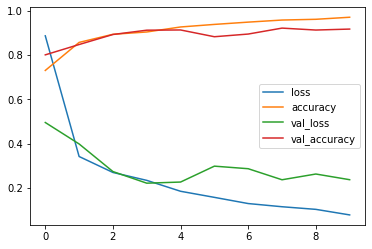

In [374]:
pd.DataFrame(model.history.history).plot()

### predict

In [375]:
from sklearn.metrics import confusion_matrix, classification_report

score = model.evaluate(input_test, label_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

preds = model.predict_classes(input_test)
print(confusion_matrix(label_test, preds))
print(classification_report(label_test, preds))

Test loss: 0.13518877672278998 / Test accuracy: 0.9562731385231018
[[2639  102]
 [  28  204]]
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98      2741
         1.0       0.67      0.88      0.76       232

    accuracy                           0.96      2973
   macro avg       0.83      0.92      0.87      2973
weighted avg       0.96      0.96      0.96      2973



In [376]:
mat = np.ndarray(shape = (2, 2), dtype = int)
mat[0][0] = confusion_matrix(label_test, preds)[1][1]
mat[0][1] = confusion_matrix(label_test, preds)[1][0]
mat[1][0] = confusion_matrix(label_test, preds)[0][1]
mat[1][1] = confusion_matrix(label_test, preds)[0][0]
print( mat )

[[ 204   28]
 [ 102 2639]]


### save model

In [377]:
model.save('../models/MAIN270eql.h5')

----
<br>
<br>
<br>

### Default model

In [109]:
# Create the model
model_new = Sequential()
model_new.add(Conv2D(50, kernel_size=(3, 3), activation='relu', input_shape = input_shape))
model_new.add(MaxPool2D())
model_new.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_new.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_new.add(MaxPool2D())
model_new.add(Flatten())
model_new.add(Dense(128, activation='relu'))
model_new.add(Dropout(0.5))
model_new.add(Dense(no_classes, activation='sigmoid'))

# Display a model summary
model_new.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 48, 48, 50)        500       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 24, 24, 50)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 22, 22, 64)        28864     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 20, 20, 64)        36928     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 6400)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)             

In [110]:
# Compile the model
model_new.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

In [113]:
model_new.fit(input_train, label_train,
            batch_size=batch_size,
            epochs=15,
            verbose=verbosity,
            validation_data=(input_val, label_val))

Train on 14038 samples, validate on 2973 samples
Epoch 1/15
14038/14038 [==============================] - 111s 8ms/sample - loss: 0.3541 - accuracy: 0.8582 - val_loss: 0.2607 - val_accuracy: 0.9088
Epoch 2/15
14038/14038 [==============================] - 111s 8ms/sample - loss: 0.3180 - accuracy: 0.8750 - val_loss: 0.2263 - val_accuracy: 0.9173
Epoch 3/15
14038/14038 [==============================] - 111s 8ms/sample - loss: 0.2784 - accuracy: 0.8921 - val_loss: 0.2044 - val_accuracy: 0.9240
Epoch 4/15
14038/14038 [==============================] - 111s 8ms/sample - loss: 0.2506 - accuracy: 0.9006 - val_loss: 0.2347 - val_accuracy: 0.9139
Epoch 5/15
14038/14038 [==============================] - 111s 8ms/sample - loss: 0.2265 - accuracy: 0.9143 - val_loss: 0.2056 - val_accuracy: 0.9277
Epoch 6/15
14038/14038 [==============================] - 111s 8ms/sample - loss: 0.2046 - accuracy: 0.9224 - val_loss: 0.1970 - val_accuracy: 0.9277
Epoch 7/15
14038/14038 [===========================

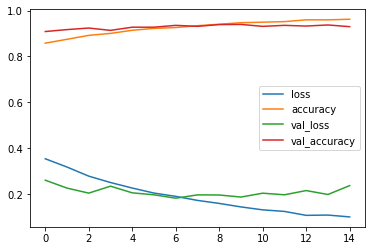

In [114]:
pd.DataFrame(model_new.history.history).plot()

In [115]:
from sklearn.metrics import confusion_matrix, classification_report

score = model_new.evaluate(input_test, label_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

preds = model_new.predict_classes(input_test)
print(confusion_matrix(label_test, preds))
print(classification_report(label_test, preds))

Test loss: 0.08116494042230622 / Test accuracy: 0.9764547348022461
[[2694   47]
 [  23  209]]
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      2741
         1.0       0.82      0.90      0.86       232

    accuracy                           0.98      2973
   macro avg       0.90      0.94      0.92      2973
weighted avg       0.98      0.98      0.98      2973

